<a href="https://colab.research.google.com/github/hangoc2508/Econometrics-project/blob/main/Econometrics_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
install.packages("haven")
install.packages("tidyverse")
install.packages("readxl")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in install.packages("haven"):
“installation of package ‘haven’ had non-zero exit status”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [50]:
library(haven)
library(tidyverse)
library(readxl)

In [51]:
brfss <- read.csv("/content/brfss_all_except 2019.csv")
nrow(brfss)

head(brfss,3)

[1] 2406478

,state,interview_month,interview_year,age_group,sex,education_level,employment_status,househole_income,number_children_household,race,cig_status,ecig_status,drinks_daily,drinks_weekly,binge_drink_status,heavy_drink_status
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,1,2016,5,1,4,1,5,3,1,4,1,0,0,1,1
2,1,1,2016,8,2,4,5,7,88,1,4,1,0,0,1,1
3,1,1,2016,13,2,5,7,7,88,1,1,1,14,100,1,1


# Task
Create a dummy variable column named `tax_implemented` in the `brfss` dataframe. The column should indicate whether a tax was implemented (1) or not (0) based on the tax implementation data provided in CDC state tax control. The dummy variable should be based on the state, year, and month of the data point in the `brfss` dataframe, considering the effective month and year from the `tax` dataframe. Note that for 2016, Pennsylvania's effective month is October and West Virginia's is July, which should be handled in addition to the data in the Excel file.

## Prepare tax data

### Subtask:
Clean and format the `tax_df` to easily join with `brfss`, including handling the 2016 exceptions for Pennsylvania and West Virginia.


**Reasoning**:
Clean and format the `tax_df` dataframe, handle missing values, rename columns, convert effective month to numerical representation, add 2016 exceptions for Pennsylvania and West Virginia, and combine with the original dataframe, ensuring consistent data types for join keys.



In [52]:
tax <- read_xlsx("/content/Tax_implementation_with_FIPS_effective date.xlsx")
# tax_clean must contain one effective date per state (earliest if multiple)
tax_clean <- tax %>%
  transmute(
    FIPS_state      = as.integer(FIPS_Code),
    effective_year  = as.integer(effective_year),
    effective_month = as.integer(effective_month)
  ) %>%
  mutate(
    # special cases for 2016
    effective_month = dplyr::case_when(
      FIPS_state == 42L & effective_year == 2016L ~ 10L, # PA → Oct 2016
      FIPS_state == 54L & effective_year == 2016L ~  7L, # WV → Jul 2016
      TRUE ~ effective_month
    )
  ) %>%
  arrange(FIPS_state, effective_year, effective_month) %>%
  distinct(FIPS_state, .keep_all = TRUE) %>%
  mutate(effective_ym = effective_year * 12L + effective_month)

##--- Build brfss2 and add the two dummies -----------------------------------
brfss2 <- brfss %>%
  mutate(
    FIPS_state      = as.integer(state),         # temporary for the join
    interview_year  = as.integer(interview_year),
    interview_month = as.integer(interview_month),
    interview_ym    = interview_year * 12L + interview_month
  ) %>%
  filter(interview_year != 2025) %>% # Filter out year 2025
  left_join(
    tax_clean %>% select(FIPS_state, effective_year, effective_month, effective_ym),
    by = "FIPS_state"
  ) %>%
  mutate(
    # already-in-sample "post" dummy
    tax_implemented = if_else(
      !is.na(effective_ym) & !is.na(interview_ym) & interview_ym >= effective_ym, 1L, 0L
    ),
    # 1 if interview happens in the exact implementation month/year
    tax_implemented_month = if_else(
      !is.na(effective_year) & !is.na(effective_month) &
      interview_year == effective_year & interview_month == effective_month,
      1L, 0L
    ),
    # 1 if interview happens in the implementation year
    tax_implemented_year  = if_else(
      !is.na(effective_year) & interview_year == effective_year,
      1L, 0L
    )
  ) %>%
  # drop helper columns so they are NOT included in brfss2
  select(-FIPS_state, -effective_year, -effective_month, -effective_ym, -interview_ym)

head(brfss2,3)

,state,interview_month,interview_year,age_group,sex,education_level,employment_status,househole_income,number_children_household,race,cig_status,ecig_status,drinks_daily,drinks_weekly,binge_drink_status,heavy_drink_status,tax_implemented,tax_implemented_month,tax_implemented_year
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,1,2016,5,1,4,1,5,3,1,4,1,0,0,1,1,0,0,0
2,1,1,2016,8,2,4,5,7,88,1,4,1,0,0,1,1,0,0,0
3,1,1,2016,13,2,5,7,7,88,1,1,1,14,100,1,1,0,0,0


In [53]:
nrow(brfss2)

[1] 2392682

In [54]:
set.seed(250820) # just so that everyone have the same sample for comparison
brfss_sample = brfss2[ sample(nrow(brfss2),5000), ]

In [55]:
write.csv(brfss_sample , "brfss2_sample_with_tax_dummies.csv", row.names = FALSE, na = "")

# Task
Create histograms of percentage of ecigarette, cigarete, alcohol usage (daily, weekly, binge and heavy drinker) from year 2016-2024 using data from the file "brfss2.csv".

## EDA

### Histogram of average usage from 2016-2024:
Select the relevant columns for plotting from `brfss2` and calculate the percentage for each usage category.

For year 2018-2020, due to the fact that many respondent reported to omit answering Ecigarette status, I used data from NHIS to calculate the average usage of ecigrette for those year.

I try to calculate manually from the available data in BRFSS, resulting in a really large percentage compared to other years, indicating this method didn't reflect the true population usage.

**Reasoning**:
Select relevant columns, group by year, and calculate the percentage for each usage category, then store results in a new dataframe.



In [56]:
brfss2_percentages <- brfss2 %>%
  select(
    interview_year, ecig_status, cig_status,
    drinks_daily, drinks_weekly,
    binge_drink_status, heavy_drink_status
  ) %>%
  group_by(interview_year) %>%
  summarise(
    ecig_percentage         = 100 * mean(ecig_status == 2, na.rm = TRUE),
    cig_percentage          = 100 * mean(cig_status %in% c(1, 2), na.rm = TRUE),
    drinks_daily            = mean(drinks_daily,  na.rm = TRUE),  # average level
    drinks_weekly           = mean(drinks_weekly, na.rm = TRUE),  # average level
    binge_drink_percentage  = 100 * mean(binge_drink_status == 2, na.rm = TRUE),
    heavy_drink_percentage  = 100 * mean(heavy_drink_status == 2, na.rm = TRUE),
    .groups = "drop"
  )

print(brfss2_percentages)

# A tibble: 9 × 7
  interview_year ecig_percentage cig_percentage drinks_daily drinks_weekly
           <int>           <dbl>          <dbl>        <dbl>         <dbl>
1           2016            3.34           15.0         17.3          298.
2           2017            3.20           14.8         17.0          294.
3           2018           18.0            14.9         17.2          310.
4           2019           17.3            13.8         15.9          282.
5           2020           20.0            14.5         17.3          306.
6           2021            4.92           13.3         16.9          298.
7           2022            5.37           12.3         17.5          313.
8           2023            5.54           11.2         17.0          294.
9           2024            5.79           11.1         16.0          291.
# ℹ 2 more variables: binge_drink_percentage <dbl>,
#   heavy_drink_percentage <dbl>


**Reasoning**:
Generate histograms for each usage category using the calculated percentages over the years.

### Histogram for E-cigarette Usage

In [57]:
# Load NIHS
nhis <- read_dta("/content/nhis_00013.dta")

# For 2019 and 2020
# Filter out rows based on 'ecigstatus' values
nhis_2019_2020_filtered <- nhis %>%
  filter(year %in% c(2019, 2020)) %>%
  filter(!ecigstatus %in% c(0, 4, 9)) %>%
  select(year, serial, strata, psu, nhishid, ecigstatus)

# Calculate ecigarette usage from NHIS data for 2019-2020
nhis_percentages_2019_2020 <- nhis_2019_2020_filtered %>%
  group_by(year) %>%
  summarise(
    ecig_percentage = 100 * mean(ecigstatus == 3, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  rename(interview_year = year)

# For 2018, due to lack of data, only used approximation for EDA
nhis_2018_filtered <- nhis %>%
  filter(year == 2018 ) %>%
  select(year, serial, strata, psu, nhishid, eciged, ecigev)

ecig_users_2018 <- nhis_2018_filtered %>%
  filter(ecigev == 2 | eciged %in% c(1, 2))

nhis_percentage_2018_df <- data.frame(
  interview_year = 2018,
  ecig_percentage = (nrow(ecig_users_2018) / nrow(nhis_2018_filtered)) * 100
)


# Combine 2018, 2019, and 2020 NHIS percentages
nhis_ecig_percentages_combined <- bind_rows(nhis_percentage_2018_df, nhis_percentages_2019_2020) %>%
  arrange(interview_year)

print(nhis_ecig_percentages_combined)

  interview_year ecig_percentage
1           2018        5.040436
2           2019        3.848001
3           2020        2.803135


In [58]:
# Replace BRFSS ecigarette data for 2018-2020 with NHIS data
brfss2_percentages <- brfss2_percentages %>%
  rows_update(nhis_ecig_percentages_combined, by = "interview_year") %>%
  arrange(interview_year)

print(brfss2_percentages)

# A tibble: 9 × 7
  interview_year ecig_percentage cig_percentage drinks_daily drinks_weekly
           <int>           <dbl>          <dbl>        <dbl>         <dbl>
1           2016            3.34           15.0         17.3          298.
2           2017            3.20           14.8         17.0          294.
3           2018            5.04           14.9         17.2          310.
4           2019            3.85           13.8         15.9          282.
5           2020            2.80           14.5         17.3          306.
6           2021            4.92           13.3         16.9          298.
7           2022            5.37           12.3         17.5          313.
8           2023            5.54           11.2         17.0          294.
9           2024            5.79           11.1         16.0          291.
# ℹ 2 more variables: binge_drink_percentage <dbl>,
#   heavy_drink_percentage <dbl>


# Histogram for E-cigarette Usage

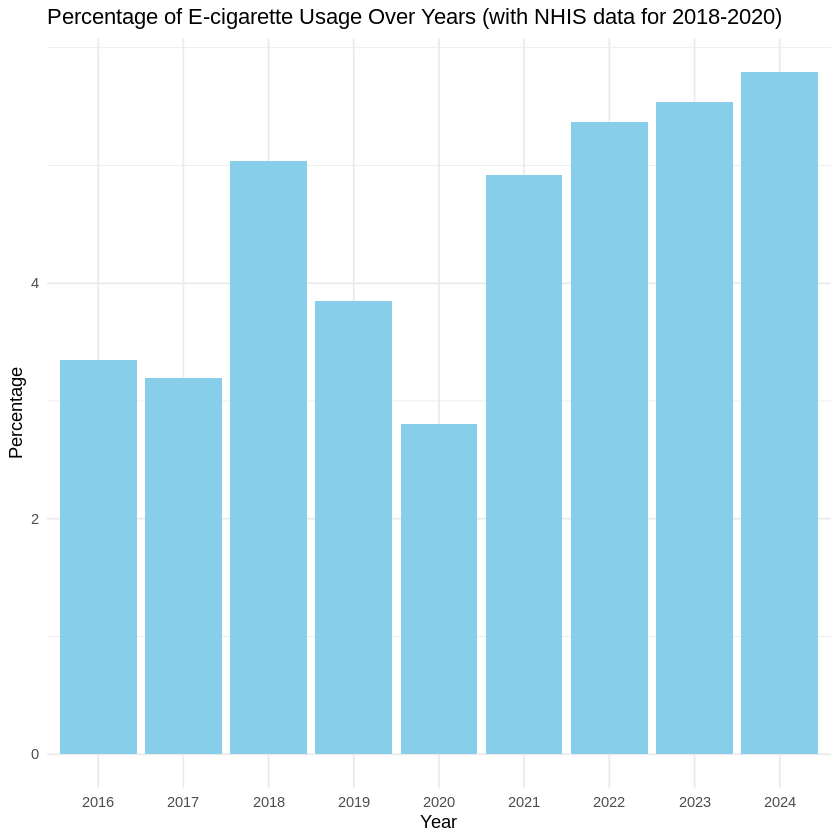

In [65]:
# Histogram for E-cigarette Usage with updated data for 2018-2020
ggplot(brfss2_percentages, aes(x = factor(interview_year), y = ecig_percentage)) +
  geom_bar(stat = "identity", fill = "skyblue") +
  labs(title = "Percentage of E-cigarette Usage Over Years (with NHIS data for 2018-2020)",
       x = "Year",
       y = "Percentage") +
  theme_minimal() +
  scale_y_continuous(breaks = seq(0, max(brfss2_percentages$ecig_percentage, na.rm = TRUE), by = 2))

### Histogram for Cigarette Usage

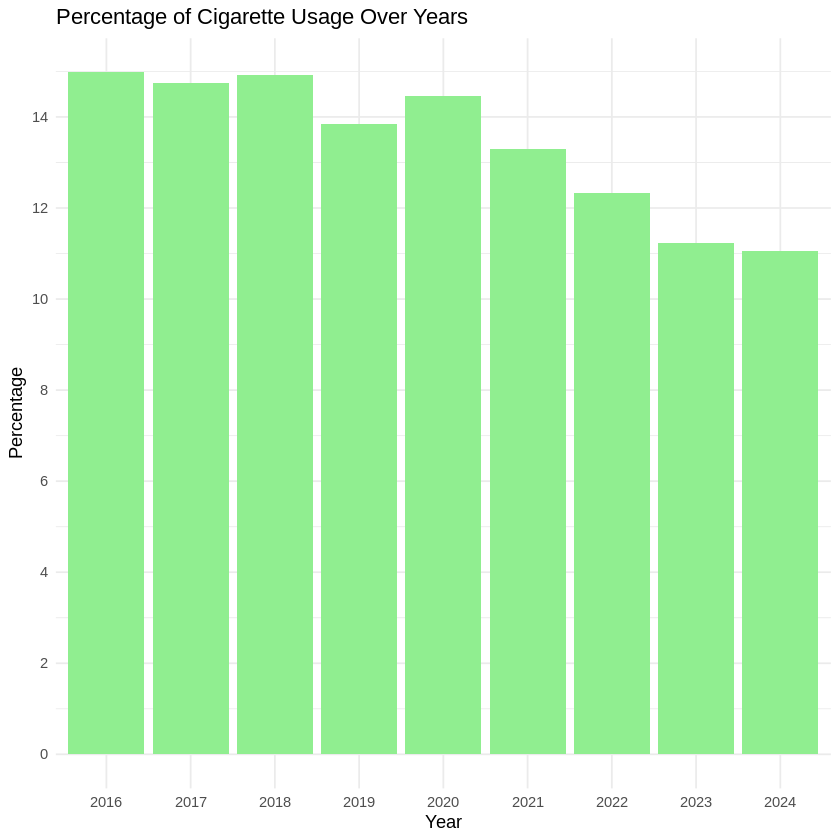

In [60]:
# Histogram for Cigarette Usage
ggplot(brfss2_percentages, aes(x = factor(interview_year), y = cig_percentage)) +
  geom_bar(stat = "identity", fill = "lightgreen") +
  labs(title = "Percentage of Cigarette Usage Over Years",
       x = "Year",
       y = "Percentage") +
  theme_minimal() +
  scale_y_continuous(breaks = seq(0, max(brfss2_percentages$cig_percentage, na.rm = TRUE), by = 2))

### Histogram for Daily Alcohol Consumption

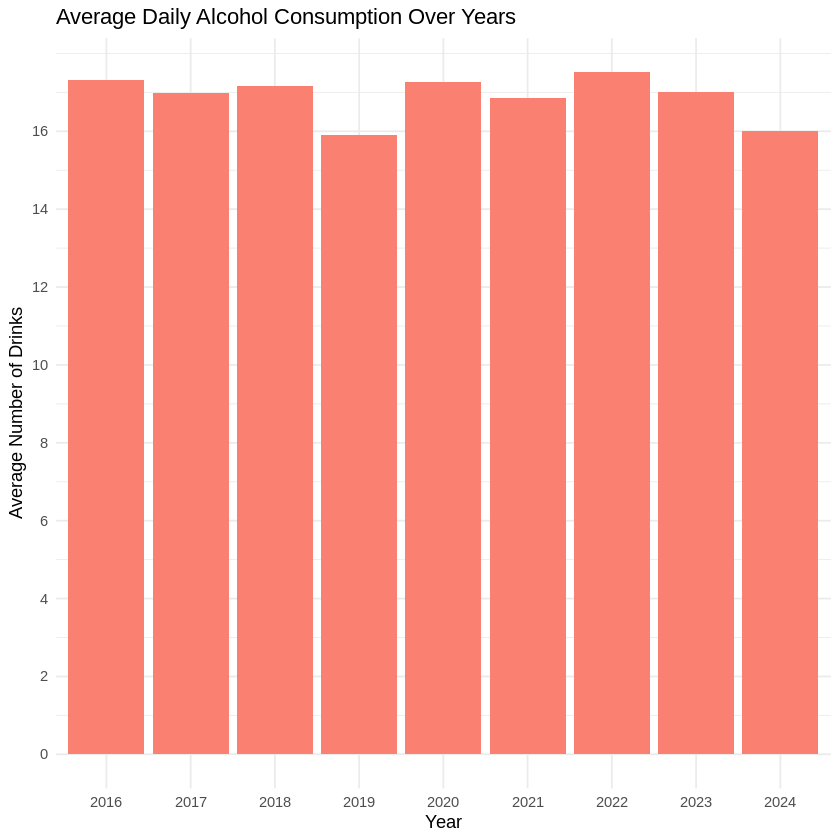

In [61]:
# Histogram for Daily Alcohol Consumption
ggplot(brfss2_percentages, aes(x = factor(interview_year), y = drinks_daily)) +
  geom_bar(stat = "identity", fill = "salmon") +
  labs(title = "Average Daily Alcohol Consumption Over Years",
       x = "Year",
       y = "Average Number of Drinks") +
  theme_minimal() +
scale_y_continuous(breaks = seq(0, max(brfss2_percentages$drinks_daily, na.rm = TRUE), by = 2))

### Histogram for Weekly Alcohol Consumption

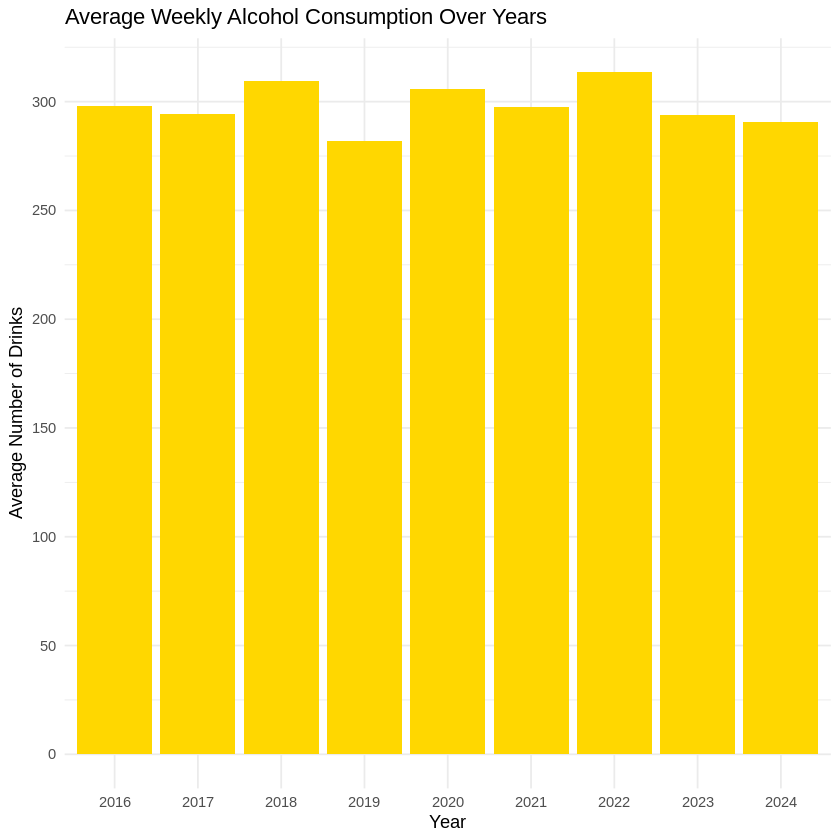

In [62]:
# Histogram for Weekly Alcohol Consumption
ggplot(brfss2_percentages, aes(x = factor(interview_year), y = drinks_weekly)) +
  geom_bar(stat = "identity", fill = "gold") +
  labs(title = "Average Weekly Alcohol Consumption Over Years",
       x = "Year",
       y = "Average Number of Drinks") +
  theme_minimal() +
scale_y_continuous(breaks = seq(0, max(brfss2_percentages$drinks_weekly, na.rm = TRUE), by = 50))

### Histogram for Binge Drinking

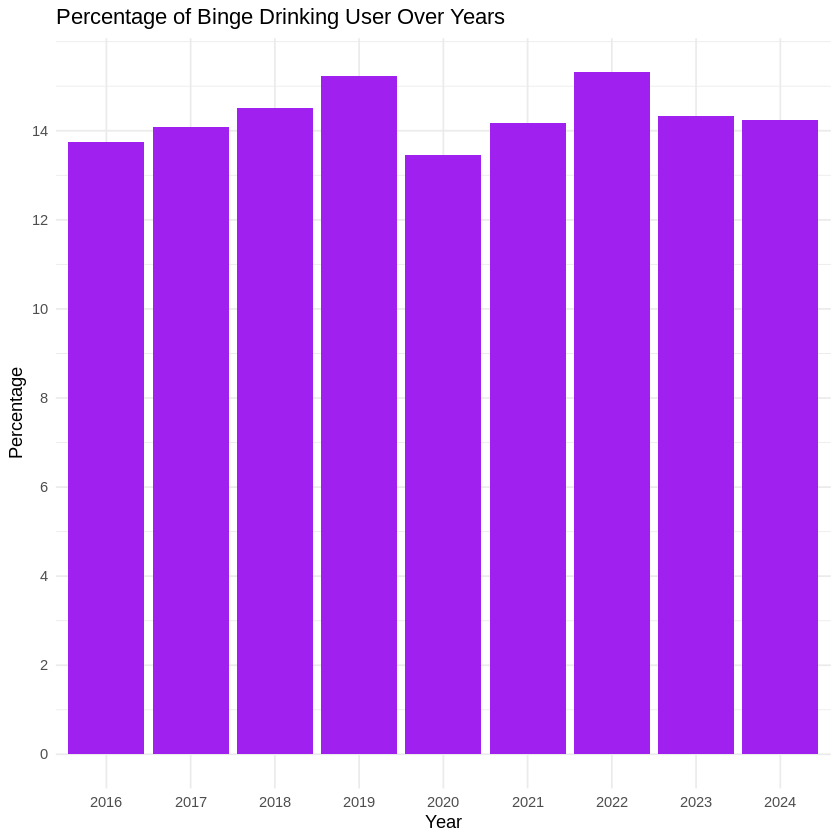

In [63]:
# Histogram for Binge Drinking
ggplot(brfss2_percentages, aes(x = factor(interview_year), y = binge_drink_percentage)) +
  geom_bar(stat = "identity", fill = "purple") +
  labs(title = "Percentage of Binge Drinking User Over Years",
       x = "Year",
       y = "Percentage") +
  theme_minimal() +
scale_y_continuous(breaks = seq(0, max(brfss2_percentages$binge_drink_percentage, na.rm = TRUE), by = 2))

### Histogram for Heavy Drinking

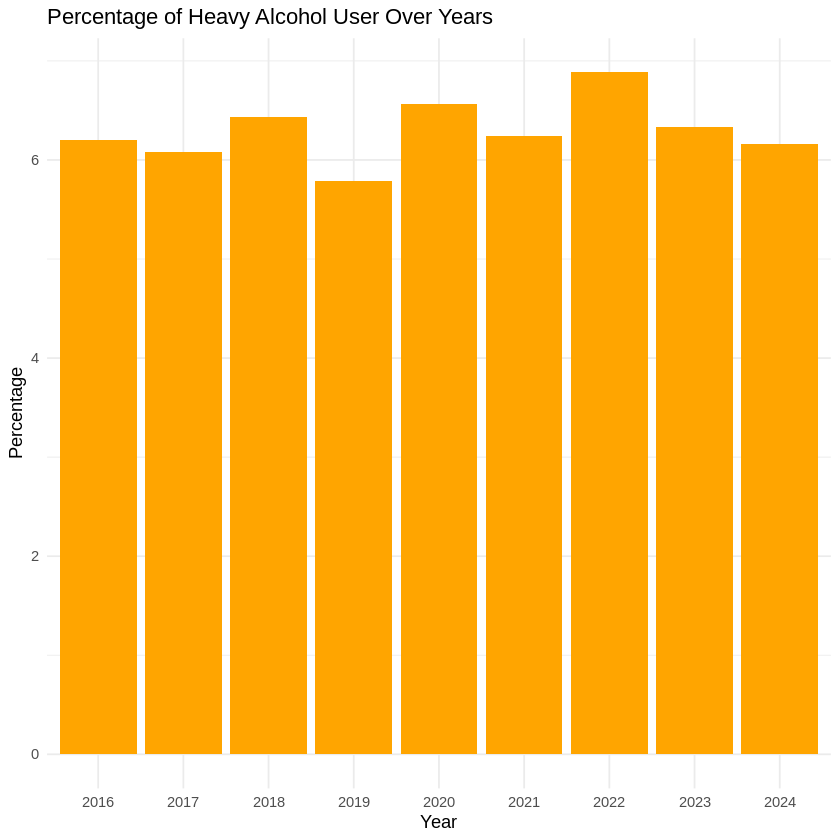

In [64]:
# Histogram for Heavy Drinking
ggplot(brfss2_percentages, aes(x = factor(interview_year), y = heavy_drink_percentage)) +
  geom_bar(stat = "identity", fill = "orange") +
  labs(title = "Percentage of Heavy Alcohol User Over Years",
       x = "Year",
       y = "Percentage") +
  theme_minimal() +
scale_y_continuous(breaks = seq(0, max(brfss2_percentages$heavy_drink_percentage, na.rm = TRUE), by = 2))